# Análisis exploratorio de datos

In [910]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Definición del problema

El cáncer de pulmón representa un reto crítico para la salud pública global, siendo la principal causa de muerte por enfermedades oncológicas en el mundo. Su alta agresividad y, con frecuencia, su diagnóstico en estadios avanzados, complican la elección del protocolo terapéutico ideal. En este escenario, el factor tiempo no es solo una variable, es el determinante fundamental de la supervivencia.

Históricamente, las decisiones médicas se han basado en guías clínicas generales y en la experiencia del especialista. Sin embargo, cada paciente es un ecosistema único condicionado por factores como el tamaño del tumor, el estadio clínico, el tipo histológico y, crucialmente, la adherencia y respuesta a tratamientos combinados de cirugía, quimioterapia y radioterapia.

Tradicionalmente, las tasas de supervivencia se calculan mediante curvas poblacionales (como Kaplan-Meier). Aunque útiles, estas curvas ofrecen una visión general pero carecen de la capacidad de personalización necesaria para predecir el destino de un individuo específico bajo diferentes escenarios terapéuticos.

Este proyecto nace de la intersección entre la oncología y la ciencia de datos. Utilizando algoritmos de Gradient Boosting (XGBoost), hemos desarrollado un sistema de predicción  que estima la probabilidad de vida en periodos anuales durante los primeros cinco años post-diagnóstico.

En este caso, trabajaremos con un conjunto de datos del SEER (National Cancer Institute) de Estados Unidos.

> "¿Cúal es la probabilidad de supervivencia de un individuo a cual se le ha diagnosticado cancer de pulmon en los proximos años?".

## Recopilación de datos

> Pagina oficial del [SEER](https://seer.cancer.gov/)

> - pegar un enlace a: README chequeo.md y modificar columnas para su explicación

### Importamos los datos y creamos el DataFrame

In [911]:
df = pd.read_csv('../data/raw/clinical_data_lung.zip')

In [912]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

> -  Este bloque de codigo nos permite visualiazar el scroll completo de los outputs.

## Análisis Descriptivo

In [913]:
df.head()

,Age recode with <1 year olds and 90+,"Race recode (White, Black, Other)",Primary Site - labeled,Histologic Type ICD-O-3,Grade Clinical (2018+),Grade Recode (thru 2017),Combined Summary Stage with Expanded Regional Codes (2004+),Derived EOD 2018 Stage Group Recode (2018+),7th Edition Stage Group Recode (2016-2017),"Derived AJCC Stage Group, 7th ed (2010-2015)",CS tumor size (2004-2015),Tumor Size Summary (2016+),Survival months,Survival months flag,Vital status recode (study cutoff used),SEER cause-specific death classification,Year of diagnosis,Median household income inflation adj to 2023,RX Summ--Surg Prim Site (1998+),Radiation recode,"Chemotherapy recode (yes, no/unk)",Sex,Rural-Urban Continuum Code,Reason no cancer-directed surgery,Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,Sequence number,Type of Reporting Source
0,65-69 years,White,"C34.1-Upper lobe, lung",8140,2,Blank(s),Regional by both direct extension and lymph no...,3A,Blank(s),Blank(s),Blank(s),070,0059,Complete dates are available and there are mor...,Alive,Alive or dead of other cause,2018,"$120,000+",33,None/Unknown,Yes,Male,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
1,65-69 years,White,C34.0-Main bronchus,8140,Blank(s),Unknown,Distant site(s)/node(s) involved,Blank(s),IV,Blank(s),Blank(s),109,0027,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2016,"$110,000 - $119,999",0,Beam radiation,Yes,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
2,65-69 years,Black,"C34.9-Lung, NOS",8041,Blank(s),Unknown,Unknown/unstaged/unspecified/DCO,Blank(s),Blank(s),UNK Stage,999,Blank(s),0000,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2014,"$110,000 - $119,999",0,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,2,0,2nd of 2 or more primaries,Physicians office/private medical practitioner...
3,80-84 years,White,"C34.1-Upper lobe, lung",8550,Blank(s),Poorly differentiated; Grade III,Regional by direct extension only,Blank(s),Blank(s),IIB,028,Blank(s),0052,Complete dates are available and there are mor...,Dead,Dead (attributable to this cancer dx),2015,"$100,000 - $109,999",33,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic
4,65-69 years,White,"C34.1-Upper lobe, lung",8140,3,Blank(s),Localized only,1B,Blank(s),Blank(s),Blank(s),033,0012,Complete dates are available and there are mor...,Dead,Alive or dead of other cause,2020,"$120,000+",0,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,3,0,2nd of 2 or more primaries,Hospital inpatient/outpatient or clinic


In [914]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537418 entries, 0 to 537417
Data columns (total 28 columns):
 #   Column                                                       Non-Null Count   Dtype 
---  ------                                                       --------------   ----- 
 0   Age recode with <1 year olds and 90+                         537418 non-null  object
 1   Race recode (White, Black, Other)                            537418 non-null  object
 2   Primary Site - labeled                                       537418 non-null  object
 3   Histologic Type ICD-O-3                                      537418 non-null  int64 
 4   Grade Clinical (2018+)                                       537418 non-null  object
 5   Grade Recode (thru 2017)                                     537418 non-null  object
 6   Combined Summary Stage with Expanded Regional Codes (2004+)  537418 non-null  object
 7   Derived EOD 2018 Stage Group Recode (2018+)                  537418 non-nu

>### Observaciones:
>
> - Existen un total de 537418 filas (en este caso, personas) y 27 columnas, entre las cuales encontramos la columna que nos ayudara a definir nuestra target `SEER cause-specific death classification`.
> - Las variables `7th Edition Stage Group Recode (2016-2017)`, `Derived AJCC Stage Group, 7th ed (2010-2015)` tienen instancias con valores nulos.
> - El resto de variables cuentan siempre con valor.
> - Los datos cuentan con 5 características numéricas y 23 características objeto.

## Limpieza de Datos

In [915]:
df.duplicated().sum()


np.int64(4977)

In [916]:
df.drop_duplicates(inplace=True)

> #### Observaciones:
>
>- Había un total de 3225 duplicados que han sido eliminados.

# cuidado ejemplo 

### Limpieza de datos: Eliminar información irrelevante

> Definimos que las variables que el algoritmo no utilizará en el proceso predictivo son:
 >
 > ejemplo a modificar `PassengerId`, `Name`, `Ticket` y `Cabin`.

> - `Type of Reporting Source` se elimina debido a la dominancia excesiva de (Hospital inpatient/outpatient or clinic) y categorías minoritarias como (Autopsy only) con apenas 454 registros.
> - `Sequence number` nos indica el número de tumores que tiene el individuo, pero para eso ya tenemos la variable de número de tumores malignos y benignos.

## Análisis de Variables

## Survival months flag

>Esta columna es el "control de calidad" de SEER, explica si los datos que se hallan en survival months son confiables determinados por  datos completos o incompletos. Para un modelo de Machine Learning, la calidad del dato es más importante que la cantidad, por lo que aquí debemos ser selectivos.

In [917]:
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival      514288
Not calculated because a Death Certificate Only or Autopsy Only case           8706
Incomplete dates are available and there cannot be zero days of follow-up      6452
Complete dates are available and there are 0 days of survival                  2058
Incomplete dates are available and there could be zero days of follow-up        937
Name: count, dtype: int64

> Complete dates are available and there are more than 0 days of survival: este valor es el más importante para el modelo, contiene los datos completos con los meses de seguimiento de los pacientes.
>
> La clasificación "Not calculated because a Death Certificate Only or Autopsy Only"  Solo se supo del cáncer cuando la persona murió (por la autopsia o el certificado) genera ruido al modelo  ya que estas personas no pudieron ser sometidas a tratamientos ni fueron sometidas a un proceso de análisis.
>
> La clasificación "Incomplete dates are available and there could be zero days of follow-up" indica:
    > - Fechas Incompletas: El registro médico puede decir "Enero de 2015" pero no el día, o simplemente "2015".
    > - Cero días de seguimiento: Al no haber fechas exactas, el sistema marca "0", pero existe la posibilidad de que el paciente haya vivido algunos días o semanas que no quedaron registrados.
    > - Seguimiento (Follow-up): Indica que el paciente "desapareció" del radar del hospital justo después del diagnóstico.
>
> Complete dates are available and there are 0 days of survival: son pacientes que no sobrevivieron más de un mes después de la detección del cáncer.

In [918]:
# características a eliminar
a_eliminar = ['Not calculated because a Death Certificate Only or Autopsy Only case', 'Incomplete dates are available and there cannot be zero days of follow-up','Incomplete dates are available and there could be zero days of follow-up']

# se sobreescribe el dataframe filtrando con las columnas que no estan en la lista
df = df[~df['Survival months flag'].isin(a_eliminar)]

In [919]:
#  Valores finales 
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival    514288
Complete dates are available and there are 0 days of survival                2058
Name: count, dtype: int64

## Age 

La variable `Age recode with <1 year olds and 90+` representa las edades de los registros.

In [920]:
df["Age recode with <1 year olds and 90+"].value_counts().sort_index()

Age recode with <1 year olds and 90+
00 years          20
01-04 years       37
05-09 years       17
10-14 years       35
15-19 years       83
20-24 years      194
25-29 years      369
30-34 years      734
35-39 years     1498
40-44 years     3395
45-49 years     8486
50-54 years    21477
55-59 years    44376
60-64 years    67586
65-69 years    88087
70-74 years    94086
75-79 years    82315
80-84 years    58385
85-89 years    31968
90+ years      13198
Name: count, dtype: int64

In [921]:
df.groupby("Age recode with <1 year olds and 90+")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Age recode with <1 year olds and 90+,,
00 years,19,1
01-04 years,32,5
05-09 years,14,3
10-14 years,28,7
15-19 years,66,17
20-24 years,139,55
25-29 years,246,123
30-34 years,427,307
35-39 years,758,740


In [922]:
# Rango para cada grupo
grupo_1 = ['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years']
grupo_2 = ['20-24 years', '25-29 years', '30-34 years', '35-39 years']
grupo_3 = ['40-44 years','45-49 years', '50-54 years', '55-59 years']
grupo_4 =['60-64 years','65-69 years', '70-74 years']
grupo_5 = ['75-79 years','80-84 years',]

# Función lógica para asignar el grupo
def asignar_grupo(edad):
    if edad in grupo_1: return 1
    if edad in grupo_2: return 2
    if edad in grupo_3: return 3
    if edad in grupo_4: return 4
    if edad in grupo_5: return 5
    else: return 6  #Todo lo que no esté en los anteriores (85+)

# Nueva columna de edad
df['age_group'] = df['Age recode with <1 year olds and 90+'].apply(asignar_grupo)

# Elimina la columna original de edad
df.drop('Age recode with <1 year olds and 90+', axis=1, inplace=True)

# Verifica los conteos
df['age_group'].value_counts().sort_index()

age_group
1       192
2      2795
3     77734
4    249759
5    140700
6     45166
Name: count, dtype: int64

>#### Observaciones:
>
> Las edades estan agrupadas en rangos dividido en 6 etapas, se procedera a reagrupar a las personas en grupos mas grandes siguiendo una lógica fisiológica y clínica.
 >
> - Grupo 1 (0-19 años): Pediátrico/Adolescente. Cánceres con biología muy distinta y alta tasa de supervivencia en muchos casos.
>
> - Grupo 2 (20-39 años): Adulto Joven. Pacientes con pocas comorbilidades (otras enfermedades) pero donde el cáncer puede ser más agresivo.
>
> - Grupo 3 (40-59 años): Adulto Medio. La etapa donde aumenta la incidencia; es el "estándar" del dataset.
>
> - Grupo 4 (60-74 años): Adulto Mayor. Comienzan a aparecer otros problemas de salud que afectan y condicionan la elección el tratamiento.
>
> - Grupo 5 (75-84 años): Adulto Mayor. Pacientes con fragilidad clínica moderada. las complicaciones derivadas del tratamiento pueden comprometer la calidad de vida tanto como la progresión de la enfermedad.
>
> - Grupo 6 (+85): Gerátrico. El riesgo de mortalidad no relacionada con el cáncer es muy alto y los tratamientos suelen ser menos invasivos. Predominan los cuidados paliativos, priorizando la preservación de la funcionalidad sobre la supervivencia libre de progresión.



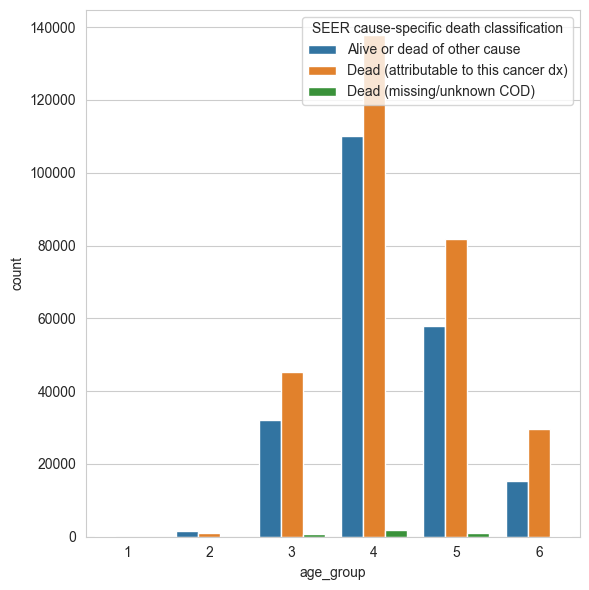

In [923]:
fig, axis = plt.subplots(figsize=(6, 6))
sns.countplot( data=df, x=df["age_group"], hue="SEER cause-specific death classification")
plt.tight_layout()
plt.show()

## sex

In [924]:
df.groupby("Sex")["SEER cause-specific death classification"].value_counts().unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
Sex,,,
Female,115579,136193,1486
Male,101537,159416,2135


> #### Observaciones:
> El sexo no es una variable indicativa fuerte para individuos masculinos y femeninos.

## Race recode (White, Black, Other)

In [925]:
# cambia el nombre de la columna a Race
df.rename(columns={'Race recode (White, Black, Other)': 'Race'}, inplace=True)

df["Race"].value_counts()

Race
White                                                        417788
Black                                                         55210
Other (American Indian/AK Native, Asian/Pacific Islander)     41656
Unknown                                                        1692
Name: count, dtype: int64

In [926]:
df.groupby("Race")["SEER cause-specific death classification"].value_counts().unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
Race,,,
Black,22349,32472,389
"Other (American Indian/AK Native, Asian/Pacific Islander)",18479,22560,617
Unknown,1171,468,53
White,175117,240109,2562


> Se observan 4 tipos de caracteristicas, agruparemos  las caracteristicas de Other con Unknown en una sola caracteristica "Other"

In [927]:
# Define la lista de las categorías que se quieren agrupar
a_renombrar = ['Other (American Indian/AK Native, Asian/Pacific Islander)', 'Unknown']

# Reemplaza esos valores por 'Other'
df['Race'] = df['Race'].replace(a_renombrar, 'Other')

In [928]:
df.groupby("Race")["SEER cause-specific death classification"].value_counts().unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
Race,,,
Black,22349,32472,389
Other,19650,23028,670
White,175117,240109,2562


> #### Observaciones: 
>
> - La raza no es una variable indicativa fuerte de supervivencia para el cáncer de pulmón.

## 'Rural-Urban Continuum Code'

In [929]:
df['Rural-Urban Continuum Code'].value_counts().sort_index()

Rural-Urban Continuum Code
Counties in metropolitan areas ge 1 million pop                 279449
Counties in metropolitan areas of 250,000 to 1 million pop      109368
Counties in metropolitan areas of lt 250 thousand pop            45091
Nonmetropolitan counties adjacent to a metropolitan area         47954
Nonmetropolitan counties not adjacent to a metropolitan area     33663
Unknown/missing/no match (Alaska or Hawaii - Entire State)         808
Unknown/missing/no match/Not 1990-2023                              13
Name: count, dtype: int64

In [930]:
df.groupby("Rural-Urban Continuum Code")["SEER cause-specific death classification"].value_counts().unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
Rural-Urban Continuum Code,,,
Counties in metropolitan areas ge 1 million pop,123062,154334,2053
"Counties in metropolitan areas of 250,000 to 1 million pop",45906,62750,712
Counties in metropolitan areas of lt 250 thousand pop,17545,27252,294
Nonmetropolitan counties adjacent to a metropolitan area,18496,29183,275
Nonmetropolitan counties not adjacent to a metropolitan area,11837,21541,285
Unknown/missing/no match (Alaska or Hawaii - Entire State),262,545,1
Unknown/missing/no match/Not 1990-2023,8,4,1


In [931]:
df.groupby("Rural-Urban Continuum Code")["SEER cause-specific death classification"].value_counts(normalize=True).unstack()

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
Rural-Urban Continuum Code,,,
Counties in metropolitan areas ge 1 million pop,0.440374,0.552280,0.007347
"Counties in metropolitan areas of 250,000 to 1 million pop",0.419739,0.573751,0.006510
Counties in metropolitan areas of lt 250 thousand pop,0.389102,0.604378,0.006520
Nonmetropolitan counties adjacent to a metropolitan area,0.385703,0.608562,0.005735
Nonmetropolitan counties not adjacent to a metropolitan area,0.351632,0.639901,0.008466
Unknown/missing/no match (Alaska or Hawaii - Entire State),0.324257,0.674505,0.001238
Unknown/missing/no match/Not 1990-2023,0.615385,0.307692,0.076923


> #### Observaciones:
>
> - Aparentemente las personas que residen en zonas urbanas suelen tener una supervivencia mayor a los más alejados de la metrópoli, esto puede ser debido a mejores centros clínicos  en zonas urbanas.
> - Las dos clasificaciones desconocidas, además de tener pocos datos no se consideran muy relevantes al porcentaje de personas que sobreviven al final de  la última fecha de estudio, por tal motivo se procede a eliminar y  cambiar el nombre de la columna a `Rural Code`.


In [932]:
df.rename(columns={'Rural-Urban Continuum Code': 'Rural Code'}, inplace=True)

# Características a eliminar
a_eliminar = ['Unknown/missing/no match (Alaska or Hawaii - Entire State)', 'Unknown/missing/no match/Not 1990-2023']

# Sobreescribe el dataframe filtrando
df = df[~df['Rural Code'].isin(a_eliminar)]

In [933]:
df['Rural Code'].value_counts()

Rural Code
Counties in metropolitan areas ge 1 million pop                 279449
Counties in metropolitan areas of 250,000 to 1 million pop      109368
Nonmetropolitan counties adjacent to a metropolitan area         47954
Counties in metropolitan areas of lt 250 thousand pop            45091
Nonmetropolitan counties not adjacent to a metropolitan area     33663
Name: count, dtype: int64

## Median household income inflation adj to 2023

In [934]:
df['Median household income inflation adj to 2023'].unique()


array(['$120,000+', '$110,000 - $119,999', '$100,000 - $109,999',
       '$95,000 - $99,999', '$90,000 - $94,999', '$85,000 - $89,999',
       '$80,000 - $84,999', '$75,000 - $79,999', '$70,000 - $74,999',
       '$65,000 - $69,999', '$60,000 - $64,999', '$55,000 - $59,999',
       '$50,000 - $54,999', '$45,000 - $49,999', '< $40,000',
       '$40,000 - $44,999'], dtype=object)

In [935]:
# Definie los grupos a partir de un mapeo manual
map_ingresos = {
    '< $40,000': 1, '$40,000 - $44,999': 1,
    '$45,000 - $49,999': 2, '$50,000 - $54,999': 2, '$55,000 - $59,999': 2, '$60,000 - $64,999': 2,
    '$65,000 - $69,999': 3, '$70,000 - $74,999': 3, '$75,000 - $79,999': 3, '$80,000 - $84,999': 3,
    '$85,000 - $89,999': 4, '$90,000 - $94,999': 4, '$95,000 - $99,999': 4, '$100,000 - $109,999': 4,
    '$110,000 - $119,999': 5, '$120,000+': 5
}

# Crea la nueva columna
df['income_level'] = df['Median household income inflation adj to 2023'].map(map_ingresos)

In [936]:
df.groupby("income_level")["SEER cause-specific death classification"].value_counts().unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
income_level,,,
1,6701,13909,187
2,39664,69163,788
3,70772,106651,1228
4,67896,75342,949
5,31813,29995,467


In [937]:
# Agrupación de niveles de ingreso por porcentaje de supervivencia 
df.groupby("income_level")["SEER cause-specific death classification"].value_counts(normalize=True).unstack().fillna(0)

SEER cause-specific death classification,Alive or dead of other cause,Dead (attributable to this cancer dx),Dead (missing/unknown COD)
income_level,,,
1,0.322210,0.668798,0.008992
2,0.361848,0.630963,0.007189
3,0.396147,0.596980,0.006874
4,0.470888,0.522530,0.006582
5,0.510847,0.481654,0.007499


In [938]:
# Eliminamos la columna original de nivel de ingresos
df.drop('Median household income inflation adj to 2023', axis=1, inplace=True)

> #### Observaciones:
>
> Dividimos los ingresos basándonos en la distribución típica de niveles de vida (Bajo, Medio-Bajo, Medio, Medio-Alto, Alto):
> - Grupo 1: Nivel Bajo (Menos de $45k) Representa a la población con mayores barreras económicas.
> - Grupo 2: Nivel Medio-Bajo ($45k - $64k)
> - Grupo 3: Nivel Medio ($65k - $84k)
> - Grupo 4: Nivel Medio-Alto ($85k - $109k)
> - Grupo 5: Nivel Alto (Más de $110k), Incluye: $110,000 - $119,999 y $120,000+.
>
> Aparentemente los ingresos del individuo están relacionados a que pueda tener mejores condiciones de salud, la capacidad de transporte a centros clínicos así como el acceso a mejores tratamientos.

## SEER cause-specific death classification

>Aquí tenemos tres tipos de clasificaciones:
Personas que no sobreviven debido al  cáncer, personas vivas o que han fallecido por causas distintas a las del cáncer y personas que han muerto pero la razón del fallecimiento es desconocida.
Para obtener el mejor modelo es importante tener casos en los que son claros los fallecimientos, por tal motivo los casos en donde se desconoce la razón de muerte serán eliminados.

In [939]:
# Define el mapeo, renombra valores
mapeo_fallecimiento = {
    'Dead (attributable to this cancer dx)': 'dead',
    'Alive or dead of other cause': 'Alive',
    "Dead (missing/unknown COD)": 'dead_unknown'
}

# Aplica el cambio
df['SEER cause-specific death classification'] = df['SEER cause-specific death classification'].map(mapeo_fallecimiento)

# Resultado final
df['SEER cause-specific death classification'].value_counts()

SEER cause-specific death classification
dead            295060
Alive           216846
dead_unknown      3619
Name: count, dtype: int64

> #### Observaciones:
> Una persona que ha fallecido por causas ajenas al cáncer (accidente u otra enfermedad) se va a considerar como viva al momento del último seguimiento ya que su muerte no ha sido debido a la enfermedad del cáncer por lo cual no se puede descartar que un tratamiento u operación hubiese sido beneficioso.
> -  Esta variable es muy importante porqué a partir de ella se obtendrá el target de supervivencia.

## Target: `target_cancer_survival`

In [940]:
# Crea el target a partir de `SEER cause-specific death classification`
df['target_cancer_survival'] = df['SEER cause-specific death classification'].apply(lambda x: 1 if 'dead' in str(x) else 0)

# Verifica el balance de clases
df['target_cancer_survival'].value_counts()

target_cancer_survival
1    298679
0    216846
Name: count, dtype: int64

mirar a ver 

In [941]:
# renombra la columna
# df.rename(columns={'SEER cause-specific death classification': 'vital_status'}, inplace=True)

----------mirar a ver

## Surival months_

In [942]:
df["Survival months"].unique()

array(['0059', '0027', '0000', '0052', '0012', '0014', '0005', '0016',
       '0040', '0010', '0009', '0001', '0020', '0002', '0021', '0025',
       '0130', '0007', '0013', '0003', '0060', '0017', '0111', '0033',
       '0004', '0090', '0037', '0062', '0024', '0008', '0006', '0076',
       '0075', '0034', '0098', '0050', '0053', '0015', '0094', '0038',
       '0078', '0026', '0128', '0125', '0042', '0058', '0091', '0051',
       '0079', '0018', '0036', '0113', '0019', '0011', '0086', '0129',
       '0030', '0092', '0101', '0032', '0070', '0084', '0126', '0056',
       '0082', '0116', '0043', '0054', '0063', '0044', '0045', '0121',
       '0123', '0102', '0074', '0057', '0081', '0028', '0023', '0099',
       '0039', '0022', '0046', '0029', '0072', '0088', '0115', '0064',
       '0061', '0108', '0073', '0035', '0120', '0031', '0068', '0055',
       '0047', '0041', '0077', '0071', '0066', '0093', '0067', '0065',
       '0083', '0117', '0085', '0100', '0118', '0105', '0069', '0124',
      

In [943]:
# Elimina valores desconocidos
df = df[~(df["Survival months"] == "Unknown")]

# Aseguramos que sea entero
df['survival_months_int'] = pd.to_numeric(df['Survival months'], errors='coerce').fillna(0).astype(int)

# Elimina la columna original
 
df = df.drop("Survival months", axis=1) 



## verificar, validar, comentar, analizar
# # 2. Definir la nueva función con rangos mixtos (de 5 en 5 y luego de 10 en 10)
# def agrupar_supervivencia_ajustado(meses):
#     if meses == 0:
#         return 0
#     elif 1 <= meses <= 6:
#         return 6
#     elif 6 < meses <= 54:
#         # Incrementos de 5 en 5 hasta los 5 años
#         return int(np.ceil(meses / 6.0) * 6)
#     else:
#         # Más de 60 meses (más de 5 años)
#         return 60

# # 3. Aplicamos la transformación
# df['survival_range'] = df['survival_months_int'].apply(agrupar_supervivencia_ajustado)

# 2. Variables del Tumor (Biología y Localización)

## Primary Site - labeled

In [944]:
df["Primary Site - labeled"].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              261469
C34.3-Lower lobe, lung              139433
C34.9-Lung, NOS                      65832
C34.2-Middle lobe, lung              22964
C34.0-Main bronchus                  20690
C34.8-Overlapping lesion of lung      5137
Name: count, dtype: int64

>#### Observaciones: 

> Indica en qué parte específica del pulmón se originó el tumor.
>
> - C34.1, C34.2, C34.3: Lóbulos superior, medio e inferior. Es vital para la supervivencia; los tumores en el lóbulo superior a veces tienen pronósticos distintos por la cercanía a grandes vasos.
>
> - C34.0 (Main bronchus): El bronquio principal. Suele ser más central y difícil de operar.
>
> - C34.9 (Lung, NOS): "Not Otherwise Specified". Significa que en la historia clínica solo dice "pulmón" sin aclarar el lóbulo.
>
> - C34.8 (Overlapping lesion): El tumor es tan grande que abarca más de un lóbulo.
>
En consecuencia a que la clasificación "C34.9-Lung NOS" no devuelve informacion sobre donde se encuentra el tumor se hace dificil tomar decisiones sobre como enfrentar a ese tumor ya que no se sabe la gravedad del mismo, por tal motivo esta clasificación crea ruido para futuras predicciones del modelo.

In [945]:
# 1. Filtrado: se toman todas las filas donde el valor sea distintos de 'C34.9-Lung, NOS'
df = df[df['Primary Site - labeled'] != 'C34.9-Lung, NOS']

# 2. Reinicio los índices para eliminar los huecos de las filas borradas
df = df.reset_index(drop=True)

#3. Renombrar la columna a Primary Site
df.rename(columns={'Primary Site - labeled': 'Primary Site'}, inplace=True)

## Histologic Type ICD-O-3 

Representa el codigo de morfología de la patologia del tumor

In [946]:
# Valores Encontrados
df["Histologic Type ICD-O-3"].unique()

array([8140, 8550, 8070, 8000, 8041, 8046, 8240, 8010, 8560, 8246, 8255,
       8551, 8012, 8254, 8252, 8230, 8480, 8073, 8071, 8260, 8250, 8022,
       8072, 8033, 8980, 8430, 8032, 8265, 8249, 8481, 8020, 8253, 8310,
       8043, 8083, 8507, 8800, 8013, 8200, 8244, 9120, 9041, 8323, 8082,
       8490, 8045, 8144, 8802, 8890, 8044, 8574, 8256, 8042, 8123, 8031,
       8084, 8830, 9040, 8973, 8004, 8251, 8052, 8075, 8575, 8074, 8470,
       9064, 8933, 8001, 8050, 9133, 8333, 9540, 8805, 8005, 9043, 8680,
       8801, 8023, 8825, 8257, 9080, 8341, 8576, 8940, 8900, 8720, 8021,
       8815, 8891, 8014, 8030, 8245, 8972, 8581, 8290, 9071, 9100, 8441,
       8562, 8810, 8120, 8201, 9180, 8811, 8803, 9473, 9044, 8854, 9260,
       8211, 8982, 8920, 8570, 8500, 8440, 8002, 8901, 8247, 8410, 8580,
       8051, 8912, 8896, 9070, 9364, 8963, 8850, 8894, 8510, 9015, 8804,
       9220, 8094, 9240, 8584, 8320, 9130, 8040, 8210, 8743, 9137, 8714,
       9370, 8806, 8035, 8003, 8078, 9561, 8936, 87

#### Agrupación por codigo
se pueden observar los códigos de Morfología de la patología los cuales se agruparan en las grandes familias del cáncer de pulmón. la reagrupación a usar:

Adenocarcinomas (Los más comunes): Códigos que empiezan por 814, 825, 826, 831, 848, 855.

Carcinomas de Células Escamosas (Epidermoides): Códigos que empiezan por 807, 808.

Células Pequeñas (Small Cell - El más agresivo): Códigos 8041, 8042, 8043, 8044, 8045.

Células Grandes (Large Cell): Códigos 8012, 8013, 8014.

Tumores Neuroendocrinos / Carcinoides: Códigos 8240, 8246, 8249.

Otros / Sarcomatoides / No Especificados: Todo lo demás (códigos 8000, 8800, etc.)

In [947]:
def agrupar_histologia_codigo(codigo):
    c = int(codigo)
    # 1. Células Pequeñas (Small Cell - Muy agresivo)
    if c in [8041, 8042, 8043, 8044, 8045]:
        return "Small Cell Carcinoma"
    # 2. Adenocarcinomas
    elif (8140 <= c <= 8149) or (8250 <= c <= 8260) or (8480 <= c <= 8490) or (c == 8550):
        return "Adenocarcinoma"
    # 3. Células Escamosas (Squamous)
    elif 8070 <= c <= 8084:
        return "Squamous Cell Carcinoma"
    # 4. Células Grandes (Large Cell)
    elif 8012 <= c <= 8014:
        return "Large Cell Carcinoma"
    # 5. Neuroendocrinos / Carcinoides
    elif 8240 <= c <= 8249:
        return "Neuroendocrine Tumors"
    # 6. Otros o No Especificados
    else:
        return "Other/NOS"

# Aplicamos la función para crear una columna de texto
df['histology_type_named'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia_codigo)

# Eliminamos la columna original de los codigos.
df.drop("Histologic Type ICD-O-3", axis=1, inplace=True)

# Verificamos los nombres
df['histology_type_named'].value_counts()



histology_type_named
Adenocarcinoma             197700
Squamous Cell Carcinoma     99346
Other/NOS                   84957
Small Cell Carcinoma        47941
Neuroendocrine Tumors       14752
Large Cell Carcinoma         4997
Name: count, dtype: int64

#### Supervivencia según `histology_type_named`

In [948]:
df.groupby("histology_type_named")["target_cancer_survival"].value_counts(normalize=True).unstack().fillna(0)

target_cancer_survival,0,1
histology_type_named,,
Adenocarcinoma,0.474987,0.525013
Large Cell Carcinoma,0.357815,0.642185
Neuroendocrine Tumors,0.714344,0.285656
Other/NOS,0.471438,0.528562
Small Cell Carcinoma,0.225277,0.774723
Squamous Cell Carcinoma,0.434180,0.565820


> #### Observaciones
> 
> 1. Carcinoma de Células Pequeñas (Small Cell Carcinoma) Es el mas agresivo, Se divide muy rápido y casi siempre se descubre cuando ya ha hecho metástasis.
> A diferencia de los otros, rara vez se opera; se trata principalmente con quimio y radio porque crece a una velocidad alarmante.
>
> 2. Carcinoma de Células Grandes (Large Cell Carcinoma): Posee el segundo nivel de agresividad. Las celulas crecen de forma desordenada y rápida en cualquier parte del pulmón. Tiene una fuerte tendencia a propagarse a los ganglios linfáticos cercanos muy pronto.
>
> 3. Carcinoma de Células Escamosas (Squamous Cell Carcinoma): Nivel  de riesgo Moderado-Alto,  Suele localizarse en el centro de los pulmones (cerca de los bronquios) y está muy ligado al tabaquismo. Aunque es agresivo, a menudo se detecta porque causa síntomas (tos con sangre) antes que otros, lo que permite operarlo si se encuentra a tiempo.
>
> 4. El más común: Adenocarcinoma: Nivel de Riesgo Moderado, es el más frecuente, especialmente en mujeres y no fumadores. 
Se localiza en la periferia del pulmón. Crece más lento que el de células pequeñas, lo que da una ventana de oportunidad más grande para cirugía.
>
> 5. Tumores Neuroendocrinos: Nivel de Riesgo: Bajo a Moderado, incluye desde los "carcinoides" (que crecen muy lento y tienen buen pronóstico) hasta variantes más agresivas.
 En general, tienen una supervivencia mucho mayor que los carcinomas mencionados anteriormente.

## CS tumor size (2004-2015) y Tumor Size Summary (2016+)

El tamaño del tumon es un dato fundamental para el analisis de supervivencia combinado con la agresividad del mismo,  es importante poder clasificarlos en terminos oncologicos, Patra esta clasificacion se implemnta una escala basada en el sistema TNM (8va Edición), que es el estándar de oro médico.


- Rango (mm),Categoría,Por qué es útil para el modelo

- 0 - 10,      Micro/T1a,Supervivencia muy alta

- 11 - 20,     T1b,Localizado

- 21 - 30,     T2a,Empieza a afectar pronóstico

- 31 - 50,     T2b,Riesgo moderado

- 51 - 70,     T3,Riesgo alto

- mayor a 70,        T4,Afectación severa / Supervivencia baja

En los datasets oncológicos (como SEER), los valores 900-999 suelen ser códigos de error o "tamaño desconocido". 

In [949]:
# conversion a tipo de dato numerico
df['CS tumor size (2004-2015)'] = pd.to_numeric(df['CS tumor size (2004-2015)'], errors='coerce')
df['Tumor Size Summary (2016+)'] = pd.to_numeric(df['Tumor Size Summary (2016+)'], errors='coerce')

# Limpieza de códigos 'desconocido' (típicamente >= 990 en registros médicos)
df.loc[df['Tumor Size Summary (2016+)'] >= 900, 'Tumor Size Summary (2016+)'] = np.nan
df.loc[df['CS tumor size (2004-2015)'] >= 900, 'CS tumor size (2004-2015)'] = np.nan


# Creacion de la columna unificada tomando el valor disponible (o el máximo si están ambos)
df['tumor_size'] = df[['Tumor Size Summary (2016+)', 'CS tumor size (2004-2015)']].max(axis=1)

# Eliminacion de valores nulos
df = df.dropna(subset=['tumor_size'])

In [950]:
# Definimos los cortes (bins) y las etiquetas
# El 900 es el límite superior común en milímetros para registros médicos
bins = [-1, 10, 20, 30, 50, 70, 900] 
labels = [10, 20, 30, 50, 70, 100]

#creación de una columna categórica según la clasificación dada
df['tumor_category'] = pd.cut(df['tumor_size'], bins=bins, labels=labels)

# transforma el tipo de dato a numerico
df['tumor_category'] = df['tumor_category'].astype(int)

#clasificación dentro de la nueva variable
df['tumor_category'].unique()

array([ 70, 100,  30,  50,  20,  10])

In [951]:
#eliminar las columnas de tamaño anteriores
df.drop(["tumor_size", "Tumor Size Summary (2016+)", "CS tumor size (2004-2015)"], axis=1, inplace=True)

df = df.reset_index(drop=True)

## Total number of in situ/malignant tumors for patient

> Representa el número de tumores malignos en las personas al momento de comenzar con el seguimiento. 

In [952]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1     269539
2      94208
3      27432
4       7224
5       1787
6        478
7        143
8         33
9         19
10         9
11         6
13         2
21         2
32         2
14         2
30         2
34         1
18         1
23         1
Name: count, dtype: int64

> #### Observaciones: 

- A partir de un total de 6 tumores cancerígenos disminuye una gran porcentaje los casos personas que tienen ese número de tumores o mayores, para evitar sesgos numéricos los casos cuyo valor de números de cáncer malignos sea mayores a 5 se clasificaron como 5.

In [953]:
#Renombrar los números de tumores 
df['Total number of in situ/malignant tumors for patient'] = df['Total number of in situ/malignant tumors for patient'].clip(upper=5)

#nueva clasificación
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1    269539
2     94208
3     27432
4      7224
5      2488
Name: count, dtype: int64

## Total number of benign/borderline tumors for patient

In [954]:
df['Total number of benign/borderline tumors for patient'].value_counts()

Total number of benign/borderline tumors for patient
0    395855
1      4871
2       156
3         8
4         1
Name: count, dtype: int64

>##### Observaciones:

- La mayoría de los registros no poseen tumores cancerígenos benignos. Para este caso de estudio no vale la pena incluir esta variable en el conjunto de datos ya que los tumores  benignos no son causantes de riesgos mortales.

In [955]:
# eliminar la  columna
df.drop(["Total number of benign/borderline tumors for patient"], axis=1, inplace=True)

## Year of diagnosis

Representa los años de los cuales se tienen registros de personas con cancer de pulmon

In [956]:
df["Year of diagnosis"].value_counts().sort_index

<bound method Series.sort_index of Year of diagnosis
2019    38312
2017    38147
2018    37596
2021    37352
2022    37139
2016    36892
2015    36511
2014    35601
2013    34605
2020    34515
2012    34221
Name: count, dtype: int64>

>#### Observaciones:

- Desde el 2012 al 2022 se han diagnosticado entre 34.000 y 39.000 cancer de pulmon por año, siendo el año 2019 el año con mayores diagnosticos de cancer de pulmon y el año 2012 con menos diagnósticos, los diagnósticos por cáncer no corresponden a la totalidad de personas con este diagnóstico, sino a las personas que han acudido a un centro clínico y por alguna razón han sido diagnosticados.

## Combined Summary Stage with Expanded Regional Codes (2004+)

Hace un resumen del tamaño y la expansión del tumor, expresado en mm

In [957]:
df["Combined Summary Stage with Expanded Regional Codes (2004+)"].value_counts().sort_index()

Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                181810
In situ                                                              3
Localized only                                                  120090
Regional by both direct extension and lymph node involvement     25893
Regional by direct extension only                                31766
Regional lymph nodes involved only                               38453
Unknown/unstaged/unspecified/DCO                                  2876
Name: count, dtype: int64

In [958]:
# Analizar si los valores  desconocidos tienen un patron comun
target_stage = "Unknown/unstaged/unspecified/DCO"

# Creamos un sub-dataset solo con esos casos
df_unknown = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] == target_stage]

# Vemos el conteo de cuántos pacientes en ese estado tienen cada rango de tamaño
conteo_por_rango = df_unknown['tumor_category'].value_counts()

print(f"Distribución de Tumor Size para el estadio: {target_stage}")
print(conteo_por_rango)

Distribución de Tumor Size para el estadio: Unknown/unstaged/unspecified/DCO
tumor_category
50     763
20     609
30     563
70     414
100    368
10     159
Name: count, dtype: int64


>#### Observaciones:
>La distribucion de los tamaños de los tumores en la clasificacion Unknown/unstaged/unspecified/DCO no predominan las categorias con tamaños mas grandes con las cuales se pudiese pensar que no se ha podido determinar el lugar de crecimiento por tal motivo estos datos podrian generar ruidos por el cual seran eliminados 

In [959]:
df = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] !=  "Unknown/unstaged/unspecified/DCO"]

## RX Summ--Surg Prim Site (1998+)

Indica el tipo de tratamiento quirúrgico que recibió el paciente en el sitio primario del tumor.

In [960]:
df["RX Summ--Surg Prim Site (1998+)"].value_counts().sort_index()


RX Summ--Surg Prim Site (1998+)
0     290914
12       655
13       205
15       256
19       133
20       374
21     18302
22      6001
23       525
24       287
25       118
30      8415
33     65271
45      1810
46       731
47        78
48        65
55       563
56      2038
65        27
66        33
70        55
80        71
90       391
99       697
Name: count, dtype: int64

>#### Observaciones:

En los datasets tipo SEER, los códigos suelen ir del 00 al 90, donde los numeros indican

- 90: Desconocido. No hay registro de si se operó o no.

- 99: DCO / Autopsia. Casos donde solo se supo del cáncer tras la muerte.

estos datos no son utiles ya que no indican que tipo de tratamiento recibio la persona y una persona a la cual se le diagnostica el cancer por medio de una Autopsia genera sesgos para la predicción de sobrevivientes pues no se sabe que condiciones clinicas poseia con respecto al tumor y no lleva un adecuado seguimiento.

In [961]:
#Asignar la columna RX Summ--Surg Prim Site (1998+) a col_surg 
col_surg = "RX Summ--Surg Prim Site (1998+)"

# Transformar a númerico
df[col_surg] = pd.to_numeric(df[col_surg], errors='coerce')

# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
df = df[~df[col_surg].isin([90, 99])]
df = df.dropna(subset=[col_surg])

In [962]:
# Funcion para asignar el tipo de cirugía segun el codigo

def agrupar_cirugia_pulmon(codigo):
    if codigo == 0:
        return 'no intervenido'  # No intervenido
    elif 10 <= codigo <= 19:
        return 'Cirugía local / Biopsia' 
    elif 20 <= codigo <= 25:
        return 'Escisión local / Resección en cuña' 
    elif codigo == 30:
        return 'Resección segmentaria'    
    elif (codigo == 33) or (45 <= codigo <= 56):
        return 'Lobectomía' 
    elif (codigo == 55) or (codigo == 56):
        return 'Bilobectomía.'
    elif (codigo == 65) or (codigo == 66):
        return 'Neumonectomía' 
    elif (codigo == 70):
        return 'Cirugía extendida' 
    else:
        return 'Otros tipos de cirugía'

df['surgery_class'] = df[col_surg].apply(agrupar_cirugia_pulmon)

In [963]:
df["surgery_class"].value_counts()

surgery_class
no intervenido                        290914
Lobectomía                             70556
Escisión local / Resección en cuña     25607
Resección segmentaria                   8415
Cirugía local / Biopsia                 1249
Otros tipos de cirugía                    71
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [964]:
# 3. Eliminamos la columna original
df = df.drop(columns=["RX Summ--Surg Prim Site (1998+)"])

## Derived EOD 2018 Stage Group Recode (2018+), 7th Edition Stage Group Recode (2016-2017), Derived AJCC Stage Group, 7th ed (2010-2015), Combined Summary Stage with Expanded Regional Codes (2004+)

In [965]:
df['Combined Summary Stage with Expanded Regional Codes (2004+)'].value_counts()


Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                181308
Localized only                                                  119758
Regional lymph nodes involved only                               38329
Regional by direct extension only                                31685
Regional by both direct extension and lymph node involvement     25844
In situ                                                              3
Name: count, dtype: int64

Estas columnas representan el Estadio AJCC (American Joint Committee on Cancer), que es básicamente la "puntuación final" de la gravedad del cáncer.

La razón por la que se tiene tres columnas diferentes es que el sistema médico se actualiza cada pocos años. SEER separa los datos según la "edición" del manual que se usaba en ese momento:

Periodos de clasificación:

- 2018+ (EOD 2018): Es la versión más moderna. Usa una lógica llamada Extent of Disease.

- 2016-2017 (7th Edition): Un periodo de transición corto usando la 7ma edición.

- 2010-2015 (7th ed): La versión consolidada de la 7ma edición.

Cada periodo de clasificación tiene codigos diferentes a los otros periodos. no obstante, el diccionario de las variables permite definir la equivalencia que tiene un tipo de codigo de un determinado periodo respecto a los otros periodos.

In [966]:
# Visualizacion de los valores correspondientes a la variable "Derived EOD 2018 Stage Group Recode (2018+)"
df["Derived EOD 2018 Stage Group Recode (2018+)"].value_counts().sort_index()
    

Derived EOD 2018 Stage Group Recode (2018+)
0                3
1A1          10351
1A2          21895
1A3          12643
1B           12420
2A            3802
2B           12544
3              687
3A           18359
3B           11878
3C            2784
4             2840
4A           28107
4B           35581
88            8363
99             969
Blank(s)    213701
Name: count, dtype: int64

In [967]:
# Visualizacion de los valores correspondientes a la variable "7th Edition Stage Group Recode (2016-2017)"
df['7th Edition Stage Group Recode (2016-2017)'].value_counts().sort_index() 

7th Edition Stage Group Recode (2016-2017)
0                 1
Blank(s)     322877
IA            15748
IB             6460
II               11
IIA            3400
IIB            3177
III             128
IIIA          10024
IIIB           4033
IV            30105
OCCULT           45
UNK Stage       799
Name: count, dtype: int64

In [968]:
# Visualizacion de los valores correspondientes a la variable "Derived AJCC Stage Group, 7th ed (2010-2015)"
df['Derived AJCC Stage Group, 7th ed (2010-2015)'].value_counts().sort_index()

Derived AJCC Stage Group, 7th ed (2010-2015)
Blank(s)     257276
IA            25764
IB            12353
II               33
IIA            6568
IIB            6671
III             491
IIIA          19405
IIIB           8059
IV            59173
UNK Stage       876
Name: count, dtype: int64

# comentar con elius

In [969]:
# Función para encapsular las 4 columnas en una sola con los valores en un mismo rango de significado.  
def encontrar_columna(lista_cols, palabra_clave):
    for c in lista_cols:
        if palabra_clave in c:
            return c
    return None

cols_actuales = df.columns.tolist()

c1 = encontrar_columna(cols_actuales, 'Combined Summary Stage with Expanded Regional Codes (2004+)')
c2 = encontrar_columna(cols_actuales, 'Derived EOD 2018 Stage Group Recode (2018+)')
c3 = encontrar_columna(cols_actuales, '7th Edition Stage Group Recode (2016-2017)')
c4 = encontrar_columna(cols_actuales, 'Derived AJCC Stage Group, 7th ed (2010-2015)')

stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

In [970]:
def simplificar_etapa(val):
    val = str(val).upper()
    if any(x in val for x in ['IV', 'DISTANT']): return 4
    if 'III' in val: return 3
    if 'II' in val: return 2
    if any(x in val for x in ['I', 'LOCALIZED']): return 1
    if any(x in val for x in ['0', 'IN SITU']): return 0
    return 'Unknown'

In [971]:
# nueva columna con el rango de valores unificados
df['Stage_Final'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa)

In [972]:
# Valores unicos en la columna
df["Stage_Final"].unique()

array([1, 4, 2, 3])

Al unificar estas variables no hacen falta conservar por separado cada una de allas.

In [973]:
# columnas que se eliminaran

df = df.drop(columns=['Combined Summary Stage with Expanded Regional Codes (2004+)',
                      'Derived EOD 2018 Stage Group Recode (2018+)',
                      'Derived AJCC Stage Group, 7th ed (2010-2015)',
                      '7th Edition Stage Group Recode (2016-2017)'])
       

In [974]:
df.columns

Index(['Race', 'Primary Site', 'Grade Clinical (2018+)',
       'Grade Recode (thru 2017)', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'age_group',
       'income_level', 'target_cancer_survival', 'survival_months_int',
       'histology_type_named', 'tumor_category', 'surgery_class',
       'Stage_Final'],
      dtype='object')

## Grade Clinical (2018+), Grade Recode (thru 2017) Y Grade Recode (thru 2017)

Los datos anteriores a 2017 solían usar una escala de 1 a 4, y a partir de 2018 se volvió más específica, Al igual que con el tamaño del tumor y el estadio, estas columnas representan el mismo concepto médico pero dividido por años de diagnóstico. El Grado (Grade) mide la agresividad biológica de las células cancerosas.

Mientras que el Estadio refleja qué tan lejos ha viajado el cáncer, el grado especifica qué tan "agresivas" o anormales se ven las células bajo el microscopio.

El grado es un predictor independiente. Esto significa que:

Dos pacientes pueden tener el mismo tamaño de tumor (ej. 30mm). Pero si el Paciente A tiene Grado 1 y el Paciente B tiene Grado 4, el Paciente B tiene una probabilidad mucho más alta de que el cáncer regrese pronto o no responda a la quimioterapia.

In [975]:

# Normalización básica
df['Grade Clinical (2018+)'] = df['Grade Clinical (2018+)'].astype(str).str.strip()
df['Grade Recode (thru 2017)'] = df['Grade Recode (thru 2017)'].astype(str).str.strip()

# Identificación de valores "vacíos"
# Reemplazar 'nan', '' (vacíos) y 'Blank(s)' por el valor de la columna antigua
df['grade_clinical'] = df['Grade Clinical (2018+)'].replace(['nan', '', 'Blank(s)'], np.nan)

# Rellena huecos con los valores en la columna Grade Recode (thru 2017)
df['grade_clinical'] = df['grade_clinical'].fillna(df['Grade Recode (thru 2017)'])

# Limpia la columna nueva en donde no se tienen valores para ninguno de los casos
df = df.dropna(subset=['grade_clinical'])


df['grade_clinical'].value_counts()

grade_clinical
9                                         126039
Unknown                                   103923
Poorly differentiated; Grade III           50267
Moderately differentiated; Grade II        40030
3                                          27557
2                                          19855
Well differentiated; Grade I               14536
1                                           7878
Undifferentiated; anaplastic; Grade IV      4945
4                                           1839
D                                             27
C                                             23
B                                              3
H                                              3
A                                              2
Name: count, dtype: int64

In [976]:
#Mapeo para la unificacion de los valores correspondientes a cada período
mapping = {
    # Grupo 1
    'Well differentiated; Grade I': '1', 'A': '1', '1': '1',
    # Grupo 2
    'Moderately differentiated; Grade II': '2', 'B': '2', '2': '2',
    # Grupo 3
    'Poorly differentiated; Grade III': '3', 'C': '3', '3': '3',
    # Grupo 4
    'Undifferentiated; anaplastic; Grade IV': '4', 'D': '4', '4': '4', 'H':'4',
    # Grupo 9
    'Unknown': '9', '9': '9'
}

# Aplica el mapeo
# Usamos .map() pero SIN .fillna(9). 
df['grade_clinical'] = df['grade_clinical'].map(mapping)
df['grade_clinical'] = pd.to_numeric(df['grade_clinical'])

In [977]:
df["grade_clinical"].value_counts()

grade_clinical
9    229962
3     77847
2     59888
1     22416
4      6814
Name: count, dtype: int64

In [978]:
df = df[df['grade_clinical'] != 9]

In [979]:
# Elimina las columnas originales
df = df.drop(['Grade Clinical (2018+)', 'Grade Recode (thru 2017)'], axis=1)

# Tratamiento realizado

> Unifica tres variables:
> - `Radiation recode`: Especifica que tipo de radicacion hubo, si fue recomendada pero rechazada y que no se le ha recomenda al paciente.
> - `Chemotherapy recode (yes, no/unk)`: Indica si al paciente se le ha aplicado o no quimioterapia.
> - `Reason no cancer-directed surgery`: Informa si al paciente se le ha sugerido cirugia y se ha llevado a cabo, si el paciente ha rechazado la cirugia y si no se ha sugerido cirugia.
> - `surgery_class`: Se refiere al tipo de cirugia que se ha realizado.

In [980]:
df["Radiation recode"].value_counts()


Radiation recode
None/Unknown                                             97734
Beam radiation                                           64272
Refused (1988+)                                           2470
Recommended, unknown if administered                      1694
Radiation, NOS  method or source not specified             511
Radioactive implants (includes brachytherapy) (1988+)      196
Combination of beam with implants or isotopes               53
Radioisotopes (1988+)                                       35
Name: count, dtype: int64

In [981]:
df['Chemotherapy recode (yes, no/unk)'].value_counts()

Chemotherapy recode (yes, no/unk)
No/Unknown    100206
Yes            66759
Name: count, dtype: int64

In [982]:
df['Reason no cancer-directed surgery'].value_counts()

Reason no cancer-directed surgery
Not recommended                                                                 89858
Surgery performed                                                               65650
Not recommended, contraindicated due to other cond; autopsy only (1973-2002)     8093
Recommended but not performed, patient refused                                   2133
Recommended but not performed, unknown reason                                     590
Recommended, unknown if performed                                                 428
Not performed, patient died prior to recommended surgery                          213
Name: count, dtype: int64

In [983]:
# Elimina los datos que fueron no recomendados debido a muerte 
df = df[~(df['Reason no cancer-directed surgery'] == 'Not recommended, contraindicated due to other cond; autopsy only (1973-2002)')]
df = df[~(df['Reason no cancer-directed surgery'] == 'Recommended, unknown if performed')]
df = df[~(df['Reason no cancer-directed surgery'] == 'Not performed, patient died prior to recommended surgery')]
Refused= [
    'Recommended but not performed, patient refused',
    'Recommended but not performed, unknown reason'
]

# Aplica el reemplazo en la columna específica
df['Reason no cancer-directed surgery'] = df['Reason no cancer-directed surgery'].replace(Refused, 'Refused')

In [984]:
df["Reason no cancer-directed surgery"].unique()

array(['Surgery performed', 'Not recommended', 'Refused'], dtype=object)

In [985]:
df["surgery_class"].value_counts()

surgery_class
no intervenido                        92581
Lobectomía                            44585
Escisión local / Resección en cuña    14187
Resección segmentaria                  6054
Cirugía local / Biopsia                 691
Otros tipos de cirugía                   48
Neumonectomía                            47
Cirugía extendida                        38
Name: count, dtype: int64

In [986]:
# Estandariza y mapea Cirugía 
df['surg_yesno'] = df['Reason no cancer-directed surgery'].map({'Surgery performed': 'C',
                                                                'Not recommended': 'Cn',
                                                                'Refused': 'Cr'
                                                                })

# Estandarizar y mapea Quimioterapia
df['chemo_yesno'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 'Q', 'No/Unknown': 'nQ'})

# Estandarizar y mapea Radiación
# Consideramos 'SÍ' a cualquier forma de radiación activa (Rs)
mapping_radiacion = {
    'Beam radiation': 'Rs',
    'Radiation, NOS  method or source not specified': 'Rs',
    'Radioactive implants (includes brachytherapy) (1988+)': 'Rs',
    'Combination of beam with implants or isotopes': 'Rs',
    'Radioisotopes (1988+)': 'Rs',
    'Refused (1988+)': 'Rr',
    'Recommended, unknown if administered': 'Rr',
    'None/Unknown': 'Rnor'
}

# Crea la nueva columna
df['rad_yesno'] = df['Radiation recode'].map(mapping_radiacion)

In [987]:
# Crea la columna de combinación (Ejemplo: S+Q+R significa Cirugía, Quimio y Radio)
df['tratamiento'] = df['surg_yesno'] + " + " + df['chemo_yesno'] + " + " + df['rad_yesno']

In [988]:
df['tratamiento'].value_counts()

tratamiento
C + nQ + Rnor     45768
Cn + Q + Rs       29411
Cn + nQ + Rnor    21526
Cn + nQ + Rs      21032
Cn + Q + Rnor     15446
C + Q + Rnor      11780
C + Q + Rs         5517
Cn + nQ + Rr       1869
C + nQ + Rs        1638
Cr + nQ + Rs       1072
Cr + nQ + Rnor      733
Cn + Q + Rr         574
C + nQ + Rr         560
Cr + nQ + Rr        400
C + Q + Rr          387
Cr + Q + Rs         368
Cr + Q + Rnor       129
Cr + Q + Rr          21
Name: count, dtype: int64

#### Visualización de pacientes que han recibido radioterapia y quimioterapia.

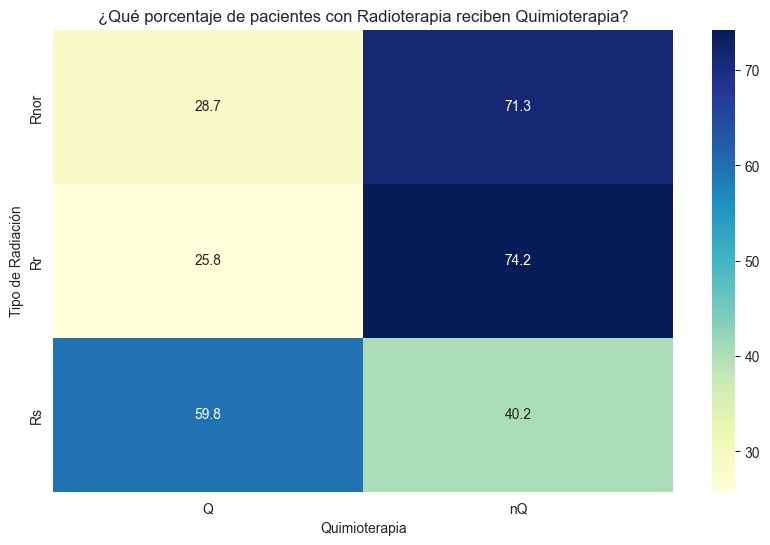

In [989]:
# Tabla de frecuencias
tabla_relacion = pd.crosstab(df['rad_yesno'], df['chemo_yesno'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(tabla_relacion, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('¿Qué porcentaje de pacientes con Radioterapia reciben Quimioterapia?')
plt.xlabel('Quimioterapia')
plt.ylabel('Tipo de Radiación')
plt.show()

> #### Observaciones:
> El 28.7% que no se les recomendo radioterapia se les realizo la quimioterapia, al 71.3% restante tampoco se les realizo quimioterapia, probablemente devido a una cirugia exitosa, un cese del seguimiento del paciente o un estado de salud delicado.
>
> El 25.8% de los pacientes que rechzaron la radiacion se sometieron a quimioterapia, el 74.2% no lo hizo.
> 
> EL 59.8% de los pacientes a los que se les realizo la radioterapia tambien recibieron quimioiterapia, al 40.2% restante, no recibio quimioterapia.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16052\91676084.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)


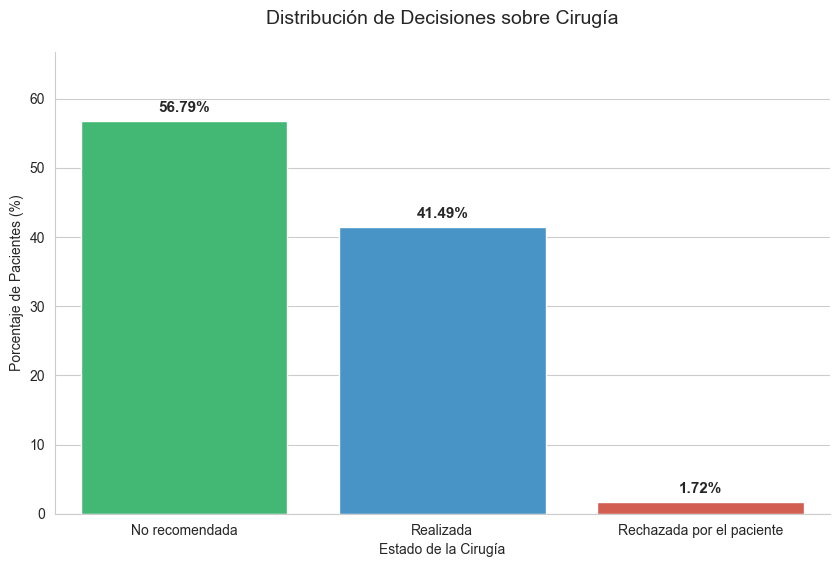

In [990]:
# Identifica el rechazo basado en el mapeo 'Cr'
# Usa la columna original de cirugía  ya estandarizada
df['status_cirugia'] = df['surg_yesno'].map({
    'C': 'Realizada',
    'Cn': 'No recomendada',
    'Cr': 'Rechazada por el paciente'
})

# Calcula porcentajes
tabla_rechazo = df['status_cirugia'].value_counts(normalize=True) * 100

# Visualización
plt.figure(figsize=(10, 6))
colores = ['#2ecc71', '#3498db', '#e74c3c'] # Verde, Azul, Rojo para el rechazo

ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)

# Añade etiquetas de porcentaje exacto sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.title('Distribución de Decisiones sobre Cirugía', fontsize=14, pad=20)
plt.ylabel('Porcentaje de Pacientes (%)')
plt.xlabel('Estado de la Cirugía')
plt.ylim(0, max(tabla_rechazo.values) + 10)
sns.despine()

plt.show()

> #### Observaciones:
> En situaciones donde al paciente no se le ha recomendado la cirugia puede deberse a los siguientes motivos: 
> - El riesgo de mortalidad no relacionada con el cánceer es muy alto y los tratamnientos suelen ser menos invasivos.
> - El cáncer ha sido diagnosticado a tiempo sus celulas pueden ser menos agresivas por lo tanto un tratamiento basado en radioterapia es suficiente.
>
> El porcentaje de rechazo a recomendaciones quirurgicas medicas es muy bajo con 1.72%

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16052\523977017.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)


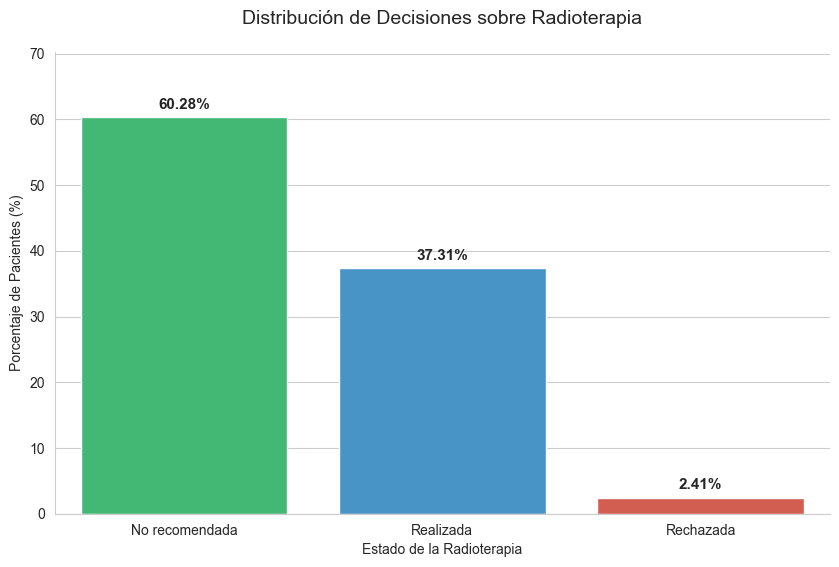

In [991]:
# Identificamos el rechazo basado en el mapeo
# Usa la columna original de Radioterapia estandarizada
df['status_rad'] = df['rad_yesno'].map({
    'Rs': 'Realizada',
    'Rr': 'Rechazada',
    'Rnor': 'No recomendada'
})

# Calcula porcentajes
tabla_rechazo = df['status_rad'].value_counts(normalize=True) * 100

# Visualización
plt.figure(figsize=(10, 6))
colores = ['#2ecc71', '#3498db', '#e74c3c'] # Verde, Azul, Rojo para el rechazo

ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)

# Añade etiquetas de porcentaje exacto sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.title('Distribución de Decisiones sobre Radioterapia', fontsize=14, pad=20)
plt.ylabel('Porcentaje de Pacientes (%)')
plt.xlabel('Estado de la Radioterapia')
plt.ylim(0, max(tabla_rechazo.values) + 10)
sns.despine()

plt.show()

> #### Observaciones:
> En medicina, la decisión de no recomendar radioterapia no suele ser porque el tratamiento sea "malo" en sí, sino porque, tras evaluar el balance entre beneficio y riesgo, los médicos determinan que el daño a los tejidos sanos superaría la ayuda que podría brindar.
> - Si el paciente ya tiene una función pulmonar muy pobre, sus pulmones no podrían tolerar la inflamación (neumonitis) que causa la radiación. En estos casos, el tratamiento podría dejar al paciente con una insuficiencia respiratoria severa.
> - Si un paciente está muy debilitado físicamente o tiene otras enfermedades crónicas graves, es posible que no pueda tolerar los efectos secundarios o el rigor de asistir a sesiones diarias de tratamiento durante varias semanas.
> - Tumores muy grandes: Si el cáncer ocupa un área demasiado extensa, la dosis de radiación necesaria para eliminarlo dañaría demasiado tejido sano adyacente.
> - Cercanía a órganos críticos: Si el tumor está pegado al corazón, al esófago o a la médula espinal, a veces el riesgo de causar una lesión permanente en esos órganos es demasiado alto.
>
> En algunos casos de cáncer de pulmón en etapas muy tempranas, si la cirugía logró extirpar todo el tumor con márgenes limpios y no hay afectación de ganglios, la radioterapia no se recomienda simplemente porque no es necesaria y no aportaría un beneficio adicional.
>
> El porcentaje de rechazo suele ser muy bajo 2.41% (motivos desconocidos).


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16052\2605038020.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)


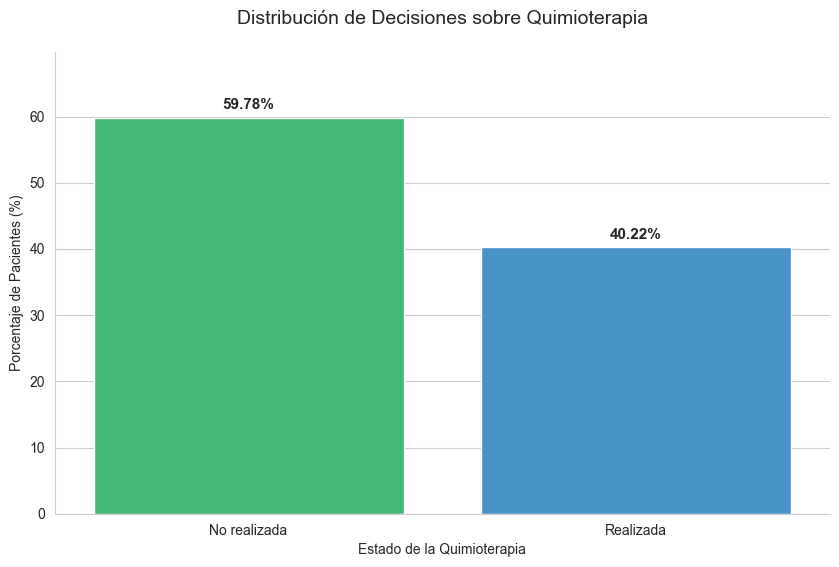

In [992]:
# Identificamos el rechazo basado en el mapeo
# Usa la columna original de Quimioterapia estandarizada
df['status_chemo'] = df['chemo_yesno'].map({
    'Q': 'Realizada',
    'nQ': 'No realizada'
})

# Calcula porcentajes
tabla_rechazo = df['status_chemo'].value_counts(normalize=True) * 100

# Visualización
plt.figure(figsize=(10, 6))
colores = ['#2ecc71', '#3498db'] # Verde, Azul, Rojo para el rechazo

ax = sns.barplot(x=tabla_rechazo.index, y=tabla_rechazo.values, palette=colores)

# Añade etiquetas de porcentaje exacto sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.title('Distribución de Decisiones sobre Quimioterapia', fontsize=14, pad=20)
plt.ylabel('Porcentaje de Pacientes (%)')
plt.xlabel('Estado de la Quimioterapia')
plt.ylim(0, max(tabla_rechazo.values) + 10)
sns.despine()

plt.show()

In [993]:
df.columns

Index(['Race', 'Primary Site', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'age_group',
       'income_level', 'target_cancer_survival', 'survival_months_int',
       'histology_type_named', 'tumor_category', 'surgery_class',
       'Stage_Final', 'grade_clinical', 'surg_yesno', 'chemo_yesno',
       'rad_yesno', 'tratamiento', 'status_cirugia', 'status_rad',
       'status_chemo'],
      dtype='object')

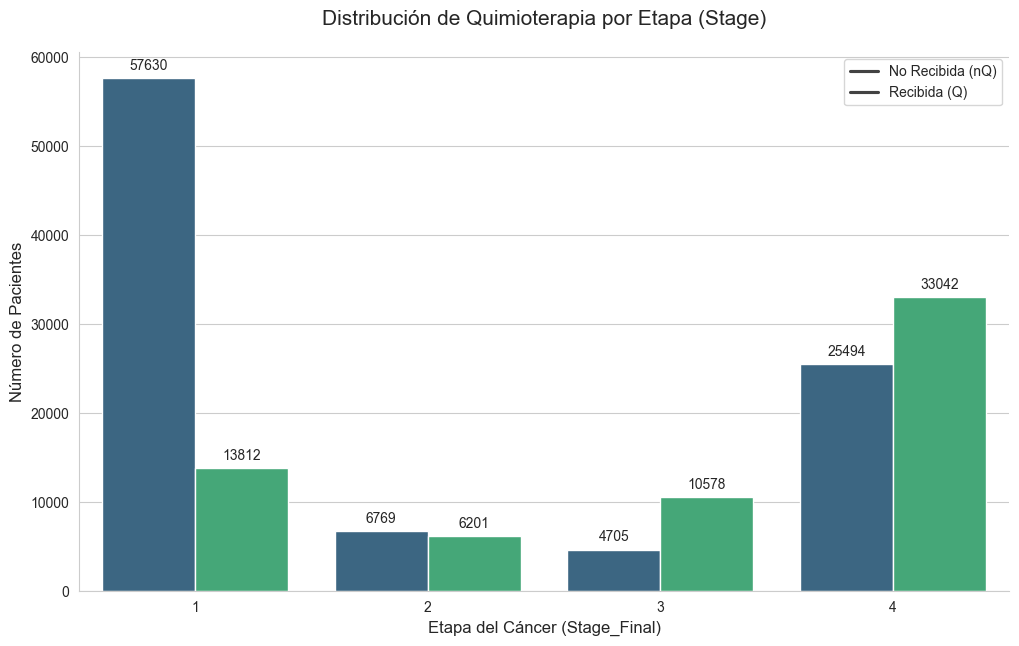

In [994]:
# 1. Preparamos los datos
# Reseteamos el índice para que 'Stage_Final' y 'chemo_yesno' sean columnas tratables por el gráfico
df_plot = df.groupby('Stage_Final')['chemo_yesno'].value_counts().reset_index(name='count')

# 2. Creamos la visualización
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Usamos 'hue' para separar Q de nQ en cada Stage
ax = sns.barplot(data=df_plot, x='Stage_Final', y='count', hue='chemo_yesno', palette='viridis')

# 3. Personalización profesional
plt.title('Distribución de Quimioterapia por Etapa (Stage)', fontsize=15, pad=20)
plt.xlabel('Etapa del Cáncer (Stage_Final)', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)
plt.legend(labels=['No Recibida (nQ)', 'Recibida (Q)'])
# Añadir etiquetas de valor sobre las barras para mayor precisión
for p in ax.patches:
    if p.get_height() > 0: # Evitar etiquetas en barras vacías
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)

sns.despine()
plt.show()

> #### Observaciones:
> A medida que augmenta el `Stage_Final` augmenta la necesidad implementar la quimioterapia.
> - Muchos pacientes que no son candidatos a cirugia (tumor inoperable o riesgo alto de mortalidad) son derivados a quimioterapia como alternativa para controlar la enfermedad. 
> - Se aplica para evitar que el cancer se propague, pararetrasar su crecimiento o destruir las celulas que se desprenden del tumor principal.

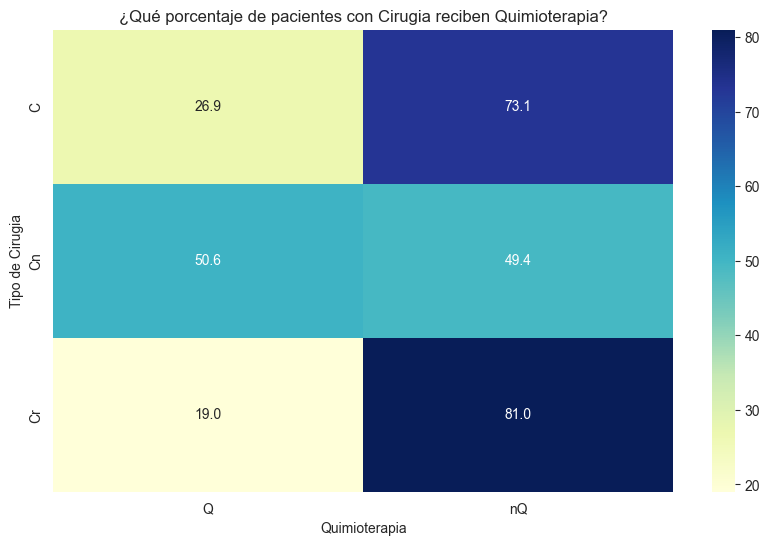

In [995]:
# Tabla de frecuencias
tabla_relacion = pd.crosstab(df['surg_yesno'], df['chemo_yesno'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(tabla_relacion, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('¿Qué porcentaje de pacientes con Cirugia reciben Quimioterapia?')
plt.xlabel('Quimioterapia')
plt.ylabel('Tipo de Cirugia')
plt.show()

> ##### Observaciones:
>
> Casi el 27% de los pacientes han recibido ambos tratamientos, Quimiotrapio y Cirugia, el 73% que recibio cirugia no recibio quimioterapia.
>
> Al 50.6% de las personas que no se les recomendo cirugia, se trataron con quimioterapia. Hay un 49.4% de personas que no se les recomendo cirugia ni recibieron quimioterapia. 
>
> El 19% de las personas que rechazaron la cirugia solo se les realizo quimioterapia. Un 81% de los pacientes que rechazaron la cirugia no fueron tratados con quimioterapia.

In [996]:
df = df.drop(["surg_yesno","chemo_yesno","rad_yesno"], axis=1)

In [997]:
df.columns

Index(['Race', 'Primary Site', 'Survival months flag',
       'Vital status recode (study cutoff used)',
       'SEER cause-specific death classification', 'Year of diagnosis',
       'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'age_group',
       'income_level', 'target_cancer_survival', 'survival_months_int',
       'histology_type_named', 'tumor_category', 'surgery_class',
       'Stage_Final', 'grade_clinical', 'tratamiento', 'status_cirugia',
       'status_rad', 'status_chemo'],
      dtype='object')

In [998]:
#si df.drop(["Vital status recode (study cutoff used)",'Chemotherapy recode (yes, no/unk)','Reason no cancer-directed surgery','Radiation recode'], axis=1, inplace=True)
df.drop(["Vital status recode (study cutoff used)"], axis=1, inplace=True)

In [999]:
df = df.drop(["Year of diagnosis","Survival months flag","surgery_class"], axis=1)

In [1000]:
df.columns

Index(['Race', 'Primary Site', 'SEER cause-specific death classification',
       'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'Sex',
       'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Sequence number', 'Type of Reporting Source', 'age_group',
       'income_level', 'target_cancer_survival', 'survival_months_int',
       'histology_type_named', 'tumor_category', 'Stage_Final',
       'grade_clinical', 'tratamiento', 'status_cirugia', 'status_rad',
       'status_chemo'],
      dtype='object')

### Guardado de modelo

In [1001]:
df.to_csv("../data/processed/df_betania.csv", index=False)

In [1002]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158231 entries, 0 to 400870
Data columns (total 23 columns):
 #   Column                                                Non-Null Count   Dtype 
---  ------                                                --------------   ----- 
 0   Race                                                  158231 non-null  object
 1   Primary Site                                          158231 non-null  object
 2   SEER cause-specific death classification              158231 non-null  object
 3   Radiation recode                                      158231 non-null  object
 4   Chemotherapy recode (yes, no/unk)                     158231 non-null  object
 5   Sex                                                   158231 non-null  object
 6   Rural Code                                            158231 non-null  object
 7   Reason no cancer-directed surgery                     158231 non-null  object
 8   Total number of in situ/malignant tumors for patient  15823

In [1003]:
# 1. Copia del dataframe para no alterar los datos de entrenamiento
df_corr = df.copy()

# 2. APLICACIÓN DE TU INSTRUCCIÓN ESPECIAL (Transformación de supervivencia)

# 3. LISTA DE VARIABLES (Las que solicitaste)
variables_interes = [
    'Race', 'Primary Site', 'Combined Summary Stage with Expanded Regional Codes (2004+)',
    'Radiation recode', 'Chemotherapy recode (yes, no/unk)',
    'Sex', 'Rural Code', 'Reason no cancer-directed surgery',
    'Total number of in situ/malignant tumors for patient', 'age_group',
    'income_level', 'target_cancer_survival',  
    'histology_type_named', 'tumor_category', 'Stage_Final', 
    'grade_clinical', 'tratamiento'
]

# 4. FACTORIZACIÓN DE CATEGÓRICAS Y SELECCIÓN
# Esto permite que .corr() procese textos como 'Race' o 'Primary Site'
for col in variables_interes:
    if col in df_corr.columns and df_corr[col].dtype == 'object':
        df_corr[col] = pd.factorize(df_corr[col])[0]

# 5. CÁLCULO DE LA MATRIZ (Usamos Spearman por ser datos con rangos/categorías)
matriz = df_corr[variables_interes].corr(method='spearman')

# 6. VISUALIZACIÓN
plt.figure(figsize=(18, 12))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación: Variables Clínicas y Rangos Personalizados")
plt.show()

KeyError: "['Combined Summary Stage with Expanded Regional Codes (2004+)'] not in index"